# Assignment: Unsupervised Machine Learning \ Clustering

## Part 1: Partitional Clustering

In this assignment you will experience with partitional & mixture model clustering. The analyses are made on real datasets under the circumstances of real life challenges in unsupervised machine learning.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Read blood test results as an EMR from an Excel file

In [2]:
# Open the file
xlsx = pd.ExcelFile('EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows

sheet1[:10]

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Use K-Means to create clusters according to variables of uniform distribution

In [3]:
# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

# Run the K-Means algorithm, assuming the correct number of clusters is 5
km_est = KMeans(5)
km_est.fit(EMR3d1)
y_pred_KMeans1 = km_est.predict(EMR3d1)

c:\Users\USER\anaconda3\envs\py4dp\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\USER\anaconda3\envs\py4dp\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Make a 3D chart

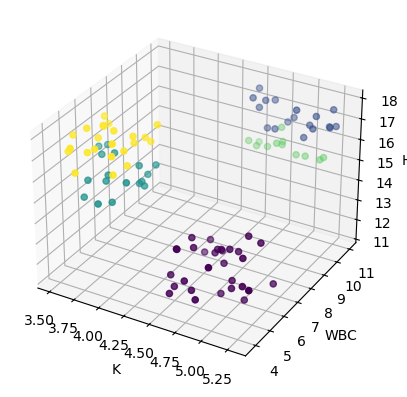

In [4]:
def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred)

make_chart(EMR3d1, y_pred_KMeans1, variables1)

## Task 1 (_max score - 50 points_)
Implement  Lloyd's Algorithm for solving the K-Means problem, as shown in class.
By examining the WCSS, choose a proper threshold to determine algorithm convergence.

Check your algorithm on 'EMR-Blood.xlsx' dataset. Compare your results to the _sklearn_ version - what can affect any differences you might've got?

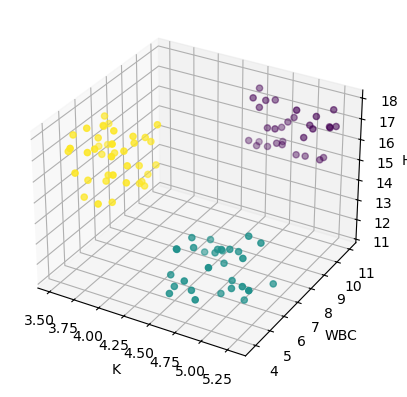

In [64]:
# Add your code for task1 after this line, and keep it in this cell.

# Implement K-Means (X being the data)
class k_means:
    def __init__(self, k):
        # assign number of clusters
        self.k = k
        self.centroids = None
        self.labels = None

    def fit(self, X):
        # randomly choose k examples as initial centroids
        centroids = np.random.default_rng().choice(X, self.k, replace=False)
        while True:
            # create k clusters by assigning each example to closest centroid
            clusters = [[] for _ in range(self.k)]
            
            dist = []
            for c in centroids:
                dist.append(np.linalg.norm((X - c), axis=1)**2)
            self.dist = [x.reshape(len(x),1) for x in dist]
            cl = np.argmin(np.hstack(self.dist), axis=1)
            cl_tab = np.hstack([X, cl.reshape(len(cl),1)])
            self.labels = cl

            for nc in range(self.k):
                clusters[nc] = cl_tab[cl_tab[:, -1] == nc][:,:-1]

            # compute k new centroids by averaging examples in each cluster
            new_centroids = [] 
            for m in clusters:
                if len(m.shape) > 1:
                    new_centroids.append(m.mean(axis=0))
                else:
                    new_centroids.append(m)

            new_centroids = np.vstack(new_centroids)

            # break if centroids don't change
            if np.array_equal(new_centroids, centroids):
                self.clusters = clusters
                self.centroids = centroids
                break

            centroids = new_centroids

    def predict(self, X):
        dist = []
        for c in self.centroids:
            dist.append(np.linalg.norm((X - c), axis=1)**2)
        dist = [x.reshape(len(x),1) for x in dist]
        cl = np.argmin(np.hstack(dist), axis=1)
        return cl


n_km_est = k_means(3)
n_km_est.fit(EMR3d1)
y_pred_nkm = n_km_est.predict(EMR3d1)
make_chart(EMR3d1, y_pred_nkm, variables1)

## Task 2 (_max score - 30 points_)

Humans can clearly spot 3 clusters, however, for machines it's much harder to "learn" that. In the above implementation, K-Means was given the value of 5 as K.
Develop a **generic** mechanism for finding the most reasonable number of clusters by:
1. Iterating K over a reasonable range, which should be derived from the number of points
2. Choose a proper K based on the heuristics learned in class
3. Showing the final clusters in a 3D chart (for your implementation of K-Means algorithm)

In [52]:
# Add your code for task2 after this line, and keep it in this cell.
def ch_kmeans(model):
    # calculate WCSS
    wcss = 0
    for i in range(model.k):
        wcss += np.linalg.norm(model.clusters[i] - model.centroids[i])**2
    
    # calculate BCSS
    cm = model.centroids.mean(axis=0)
    bcss = (np.linalg.norm(model.centroids - cm, axis=1)**2).sum()
    return wcss, bcss



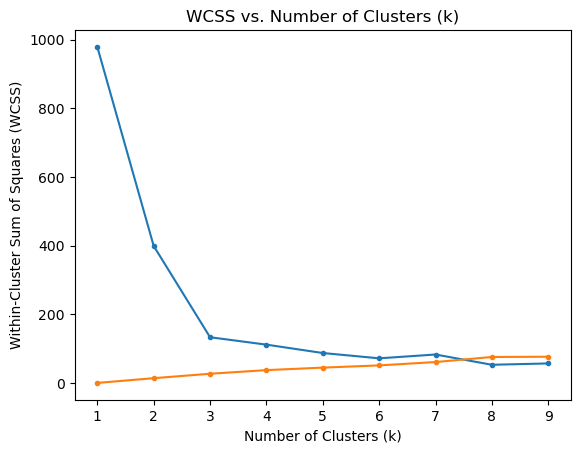

In [53]:
wcss, bcss = [], []
for k in range(1, 10):
    model = k_means(k)
    model.fit(EMR3d1)
    ch = ch_kmeans(model)
    wcss.append(ch[0])
    bcss.append(ch[1])

plt.plot(range(1, 10), wcss, marker='.')
plt.plot(range(1, 10), bcss, marker='.')
plt.title('WCSS vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()    



### Silhouette analysis

Use graphic visualization of the Silhouette score to support your above answer:

In [103]:
# Add your code for the Sillhouette graphic analysis
# You can use scikit-learn Sillhouette page as a reference

from sklearn.metrics import silhouette_samples, silhouette_score

def plot_Silhouette(X, y, num_clusters):
    # YOUR CODE HERE
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (num_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (num_clusters + 1) * 10])


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, y)
    print(
        "For num_clusters =",
        num_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y)

    y_lower = 10
    for i in range(num_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[y == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % num_clusters,
        fontsize=12,
        fontweight="bold",
    )


For num_clusters = 2 The average silhouette_score is : 0.5738344190137955
For num_clusters = 3 The average silhouette_score is : 0.644343998493909
For num_clusters = 5 The average silhouette_score is : 0.49200506285494244
For num_clusters = 7 The average silhouette_score is : 0.4671697016832463


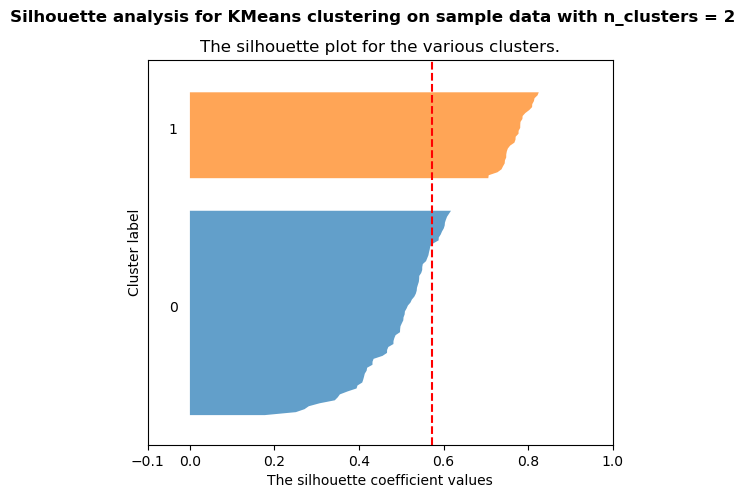

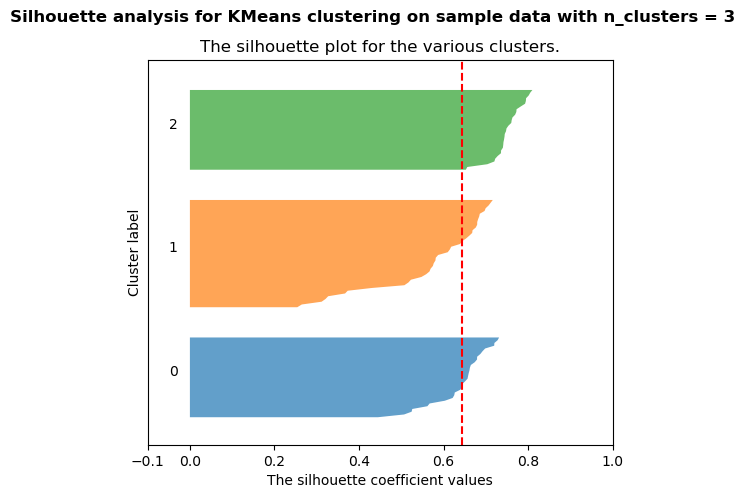

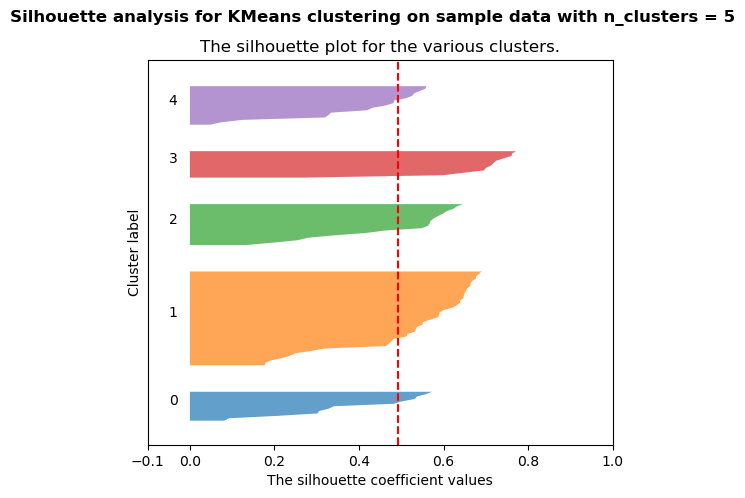

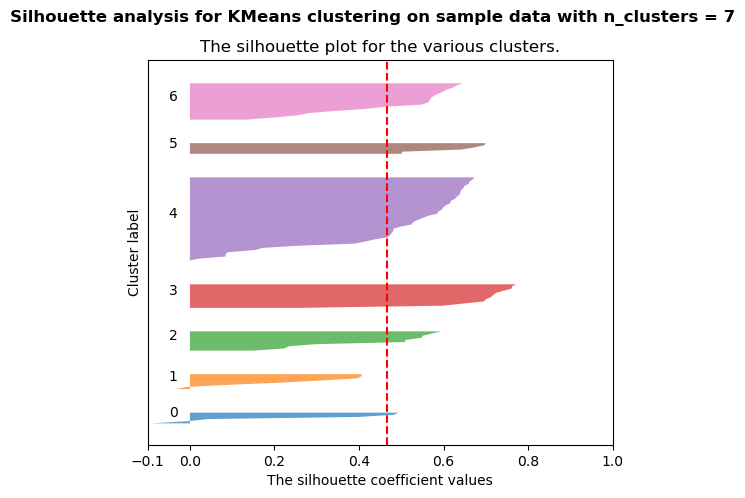

In [104]:
for k in [2, 3, 5, 7]:
    n_km_est = k_means(k)
    n_km_est.fit(EMR3d1)
    plot_Silhouette(EMR3d1, n_km_est.labels, k)

#### From this section on - please use the sklearn's K-means

## Part 2: Mixture Models Clustering

### Use K-Means to create clusters according to variables of both uniform and Gaussian distributions

In [ ]:
# Retrieve the ALT, AST and RBC column values from the dataset to cluster
variables2 = ["AST","ALT","RBC"]
EMR3d2 = sheet1.loc[:, variables2].values

# Run the K-Means algorithm
# NOTICE, this time, we know that the correct number of clusters is 2
y_pred_KMeans2 = # YOUR CODE HERE

# Make a 3D chart
make_chart(EMR3d2, y_pred_KMeans2, variables2)

## Task 3 (_max score - 20 points_)
Scientists have found that in this population of patients, RBC distribution is uniform, ALT distribution is a Gaussian and AST distribution is a mixture of two Gaussians. Clearly, even by giving K-Means the correct K, the algorithm got to the wrong conclusion. This separation is "technically" correct, but lacks some underlying understanding of the natural phenomena.

What is the "problem" with this separation?

In [ ]:
# Your answer here


In order to exploit the Gaussian characteristic of the AST
1. Find the 2 componenets that comprise the AST feature by applying the GMM algorithm with the proper number of components.
2. Assume that the clusters above are correct for the entire dataset (including the other features).
3. Show the final clusters (of EMR3d2) in a 3D chart

In [ ]:
# Add your code for task3 after this line, and keep it in this cell.




What is the difference between the two clustering results above?

Which one, given the domain knowledge provided to you, makes more sense?




# Good Luck!

